In [1]:
import rhessys.utilities as rut
from matplotlib.patches import Polygon

In [15]:
dat = pd.read_pickle('../../greenness_timing/data/p301/new_providence.pcl')
dat = dat[['datetime','SWE']]
dat.columns = ['datetime','swe']
dat.swe /= 1000. # mm > m
dat.index = pd.DatetimeIndex(dat.datetime)
del dat['datetime']

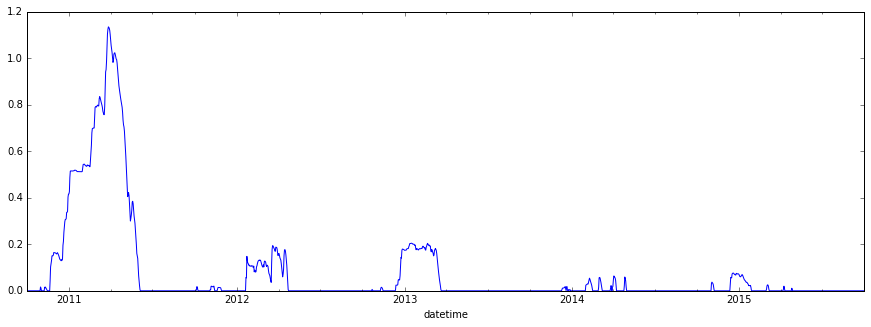

In [16]:
plt.figure(figsize=(15,5))
dat.swe.plot()

In [17]:
dat['wateryear'] = dat.index.map(rut.wateryear)

In [18]:
stats = pd.DataFrame()
stats['wateryear'] = dat.wateryear.unique()

for wy in dat.wateryear.unique():
    tmp = dat.loc[dat.wateryear == wy]
    
    dopeakswe = tmp.swe.argmax()
    peakswe = tmp.swe.max()
    
    stats.loc[stats.wateryear==wy,'doaccum'] = tmp.loc['%s-10-01'%(wy-1):dopeakswe].swe.argmin()
    stats.loc[stats.wateryear==wy,'dosnowfree'] = tmp.loc[dopeakswe:'%s-09-30'%wy].swe.argmin()
    stats.loc[stats.wateryear==wy,'dopeakswe'] = dopeakswe
    stats.loc[stats.wateryear==wy,'peakswe'] = peakswe
    

In [19]:
def compute_dowy(dt):
    year = dt.year
    month = dt.month
    day = dt.day
    wy = rut.wateryear(dt)
    
    timedelta = dt-pd.datetime.strptime('%s-10-1'%(wy-1),'%Y-%m-%d')   
    
    return timedelta.days

In [20]:
stats['dowy_accum'] = stats.doaccum.map(compute_dowy)
stats['dowy_snowfree'] = stats.dosnowfree.map(compute_dowy)
stats['dowy_peakswe'] = stats.dopeakswe.map(compute_dowy)

In [21]:
peakswe = stats.peakswe.mean()
DOAS = stats.dowy_accum.mean()
DONS = stats.dowy_snowfree.mean()
DOWYpeakSWE = stats.dowy_peakswe.mean()

peakswe90 = np.percentile(stats.peakswe,90)
DOAS90 = np.percentile(stats.dowy_accum,90)
DONS90 = np.percentile(stats.dowy_snowfree,90)
DOWYpeakSWE90 = np.percentile(stats.dowy_peakswe,90)

peakswe10 = np.percentile(stats.peakswe,10)
DOAS10 = np.percentile(stats.dowy_accum,10)
DONS10 = np.percentile(stats.dowy_snowfree,10)
DOWYpeakSWE10 = np.percentile(stats.dowy_peakswe,10)

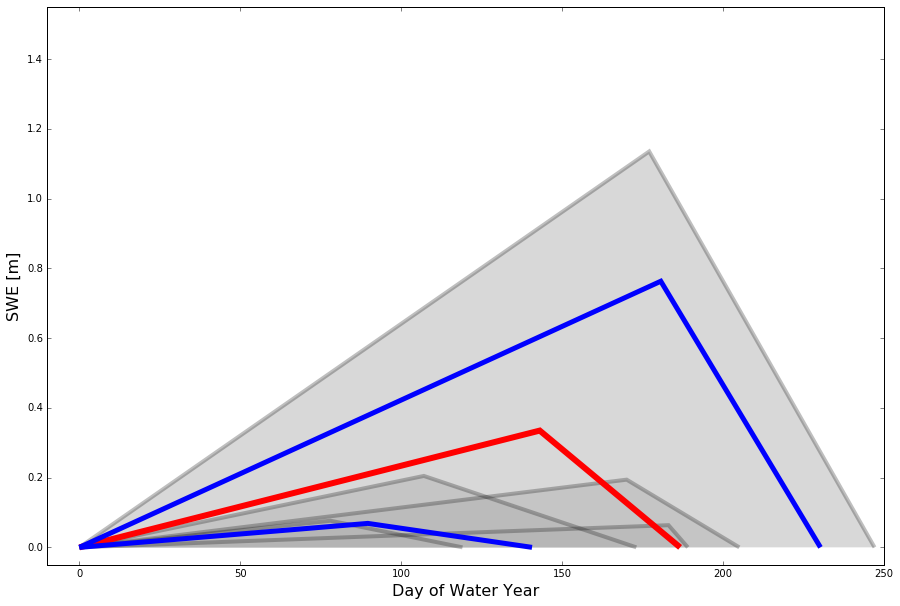

In [22]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for wy in np.unique(stats.index):
    
    x1 = stats.loc[stats.index==wy,'dowy_accum'].as_matrix()[0]
    x2 = stats.loc[stats.index==wy,'dowy_snowfree'].as_matrix()[0]
    x3 = stats.loc[stats.index==wy,'dowy_peakswe'].as_matrix()[0]
    y3 = stats.loc[stats.index==wy,'peakswe'].as_matrix()[0]
    
    pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
    p = Polygon(pts, closed=False, alpha = 0.5,edgecolor='none',facecolor='0.7')
    ax.add_patch(p)
    
for wy in np.unique(stats.index):
    
    x1 = stats.loc[stats.index==wy,'dowy_accum'].as_matrix()[0]
    x2 = stats.loc[stats.index==wy,'dowy_snowfree'].as_matrix()[0]
    x3 = stats.loc[stats.index==wy,'dowy_peakswe'].as_matrix()[0]
    y3 = stats.loc[stats.index==wy,'peakswe'].as_matrix()[0]
    
    pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
    p = Polygon(pts, closed=False, alpha = 0.25,edgecolor='k',facecolor='none',lw=4)
    ax.add_patch(p)

x1 = DOAS
x2 = DONS
x3 = DOWYpeakSWE
y3 = peakswe

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='r',facecolor='none',lw=6)
ax.add_patch(p)

x1 = DOAS10
x2 = DONS90
x3 = DOWYpeakSWE90
y3 = peakswe90

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='b',facecolor='none',lw=5)
ax.add_patch(p)

x1 = DOAS90
x2 = DONS10
x3 = DOWYpeakSWE10
y3 = peakswe10

pts = np.array([[x2,0],[x3,y3],[x1,0]])
    
p = Polygon(pts, closed=False, alpha = 1,edgecolor='b',facecolor='none',lw=5)
ax.add_patch(p)    

ax.set_xlim(-10,250)
ax.set_ylim(-.05,1.55)
plt.xlabel('Day of Water Year', fontsize = 16)
plt.ylabel('SWE [m]', fontsize=16)

In [23]:
stats.to_pickle('./data/swe_stats.pcl')